In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import collections
from collections import defaultdict
import math
from wordcloud import WordCloud
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.model_selection import  cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import fasttext
from sklearn.model_selection import cross_val_predict
import pickle
import multiprocessing
from gensim.models import Word2Vec

In [2]:
#loading the csv file

df_tweets = pd.read_csv("C:\\Users\\USER\\Documents\\Geetha\\Data Science\\Github\\Springboard\\Capstone Poject 1\\tweets_train.csv", parse_dates=True,na_values=' ',encoding="ISO-8859-1"

)


In [3]:
# performing basic preprocessing operations- setting index, replacing null values with empty strings, removing duplicate entries and
#converting text into lower case

def preprocessing(tweet):
    tweet.set_index(['time','username'], inplace = True)
    tweet.drop(['name'],axis = 1, inplace = True)
    tweet['description'] = tweet['description'].fillna('')
    tweet['location'] = tweet['location'].fillna('')
    tweet=tweet.drop_duplicates()
    tweet['description'] = tweet['description'].str.lower()
    tweet['tweets'] = tweet['tweets'].str.lower()
    return tweet

df_tweets =preprocessing(df_tweets)


In [4]:
df_tweets.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17410 entries, ('04-01-2016 01:26', 'squadsquaaaaad') to ('3/31/2016 20:25', 'wayyf44rer')
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   description     17410 non-null  object
 1   location        17410 non-null  object
 2   followers       17410 non-null  int64 
 3   numberstatuses  17410 non-null  int64 
 4   tweets          17410 non-null  object
 5   label           17410 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 978.7+ KB


In [5]:
df_tweets.columns


Index(['description', 'location', 'followers', 'numberstatuses', 'tweets',
       'label'],
      dtype='object')

In [6]:
#finding the number of unique users

df_tweets.index.get_level_values(1).value_counts(normalize=True)


Uncle_SamCoco                                                                                                                                                                                                                                                                                                       0.090752
RamiAlLolah                                                                                                                                                                                                                                                                                                         0.084721
warrnews                                                                                                                                                                                                                                                                                                            0.068409
WarReporter1                                     

In [7]:
# remove punctuations and special characters from 'tweets' column  using regular expression operations and split tweets into a list of words

def remove_punctuation(tweet):   
    tweet_tokens = [re.sub (r'http\S+', 'url', x) for x in tweet]   
    tweet_tokens = [re.sub(r'(\s)#\w+', r'\1', x) for x in tweet_tokens] 
    tweet_tokens = [re.sub(r'(\s)@\w+', r'\1', x) for x in tweet_tokens]
    tweet_tokens = [re.sub (r'[\W_]+',' ',x) for x in tweet_tokens]
    tweet_tokens_split =[x.split(" ") for x in tweet_tokens]
    return tweet_tokens_split


df_tweets['tweet_tokens_split']=remove_punctuation(df_tweets['tweets'])


In [8]:
#Removing single character words from tweet

def singlecharword_remove(tweet):
    tweet_nosinglecharword=[]
    for word_list in tweet:
        for word in word_list[:]:
            if len(word) <= 2:
                word_list.remove(word)
        tweet_nosinglecharword.append(word_list)
    return tweet_nosinglecharword

tweet_nosinglecharword=singlecharword_remove( df_tweets['tweet_tokens_split'])

In [9]:
# Manually creating a dictionary of words and replacing the words in the 'tweets' column with their root

def replace_withrootword_manual(tweet):
    list_words= ['turkey','islamicstate','syria','aleppo','warreporter1','russia', 'assad', 'iraq','url','the','abu','isis','attack','muslim','islam']
    dict_repetition=defaultdict(list)
    for word_list in tweet:
        for i, v in enumerate(word_list):
            for item in list_words:
                if item in v:          
                    word_list[i] = v.replace(v, item)
    return tweet
 

tweet_replacedwithroot_manual=replace_withrootword_manual(tweet_nosinglecharword)


In [10]:
# join the list of words in tweet column

def join_tweets(tweet):
    tweet_tokens_joined =[' '.join(words) for words in tweet]
    return tweet_tokens_joined 

In [11]:
# write the 'tweet_tokens_joined' column to a txt file

tweet_tokens_joined_rootmanual=join_tweets(tweet_replacedwithroot_manual)
df_tweets['tweet_tokens_joined'] = tweet_tokens_joined_rootmanual

df_tweets['tweet_tokens_joined'].to_csv(r'C:\Users\USER\Documents\Geetha\Data Science\Github\Springboard\Capstone Poject 1\tweets_clean.txt', header=None, index=None, sep=' ', mode='a')

In [12]:
model = fasttext.train_unsupervised('tweets_clean.txt')

In [13]:
def replace_withrootword_fasttext(tweet):   
    dict_repetition=defaultdict(list)
    threshold_fasttext=.995
    for word_list in tweet:           
            for word in set(word_list):
                for x in model.get_nearest_neighbors(word):
                    if x[0]> threshold_fasttext:                                      
                        dict_repetition[word].append(x[1])
    
    for word_list in tweet:
        for i,word in enumerate(word_list):
            for key,value in dict_repetition.items():
                if word in value:
                    word_list[i]=key  
    return tweet
tweet_replacedwithroot_fasttext = replace_withrootword_fasttext(tweet_replacedwithroot_manual)

In [14]:
#Finding the low IDF(Inverse Document Frequency ) terms to add them to the list of stop words

def tf_idf(tweet):
    tf = defaultdict(int)
    for word_list in tweet:
        for word in set(word_list):       
             tf[word]+=1             
    idf = defaultdict(int)
    count_tweets= df_tweets.tweets.count()
    for key, value in tf.items():
        idf[key]=math.log(count_tweets/(value + 1))
   
    return sorted(idf.items(), key=lambda x: x[1],reverse=False)

#tf_idf(tweet_replacedwithroot_fasttext)


In [15]:
# A list of stop words has been created manually from the low IDF(Inverse Document Frequency ) terms

stop_words_manual=['rt','abu', 'url','amp','the', 'in', 'of', 'to', 'and', 'is', 'on', 'by', 'for', 'with', '&amp;', 'from', 'are', 'you', 'they', 'that', 'this', 'it', 'us', 'was', 'have', 'their', 'will', 'an', 'who', 'be', 'as', 'after', 'at', 'he', 'al', 'but', 'its', 'has', 'his', 'one', 'were', 'if', 'all', 'today', 'them', 'we', 'city', 'people', 'about', 'your', 'now', 'when', 'ypg', 'what', 'more', 'or', 'new', 'over', 'like', 'just', 'so', 'can', 'de', 'west', 'north', 'saa','how', 'only', 'do', 'claims', 'reports', 'those', 'captured', 'fsa', 'than', 'my', 'back', 'up', 'la', 'between', 'group', 'our', 'there', 'out', 'two', 'area', 'while', 'via', 'which', 'know', 'because', 'been','see', 'le', 'coalition', 'me', 'village', 'south', 'northern', 'news', 'many', 'him', 'east', 'time', 'being', 'some', 'still', 'these', 'think', 'support', 'then', 'may', 'a', 'why', 'make', 'air','take', 'also', 'want', 'huge', 'says', 'even', 'un', 'under', 'during', 'other', 'very', 'homs','say', 'les', 'targeted', 'help', 'into','days', 'reportedly', 'eastern', 'any','said','please', 'des', 'where', 'would', 'first', 'yesterday', 'get', 'ied', 'heavy', 'report', 'day', 'security', 'same', 'twitter','im', 'ahrar', 'least', 'htt…', 'years', 'cest', 'deir','je', 'vso','rt', 'url', 'the', 'in', 'of', 'to', 'and', 'is', '', 'on', 'by', 'for', '&amp;', 'with', 'from', 'you', 'are', 'they', 'this', 'that', 'it', 'was', 'have', 'who', 'after', 'their', 'will', 'as', 'an', 'be', 'he', 'near', 'its', 'at', 'but', 'them', 'has', 
'if','plz', 'were', 'should','did','does','since','amp', 'let', 'his', 'al', 'english', 'translation', 'today', 'one', 'when', 'people', 'or', 'city', 'what', 'we', 'now', 'so', 'all', 'more', 'only','about', 'your', 'ypg', 'de', 'new', 'reports', 'just', 'over', 'saa', 'like', 'my', 'do', 'i', 'can', 'area', 'there','up', 'between', 'how', 'our', 'than', 'claims', 'group', 'out', 'may', 'la', 'huge', 'those', 'me', 'some', 'le', 'time', 'see', 'been', 'know', 'make', 'many', 'him', 'still', 'which', 'why', 'clashes', 'says', 'two', 'south', 'because', 'via', 'these', 'support', 'being', 'then', 'un', 'other', 'said', 'control', 'back', 'under', 'very', 'where', 'while', 'any', 'say', 'even', 'air', 'lol', 'during', 'eastern', 'get', 'days', 'want', 'please', 'also', 'most','first', 'im', 'into', 'another', 'les', 'would', 'positions', 'reportedly', '&gt']

stop_words_manual = list(set(stop_words_manual))



In [16]:
# write the new 'tweet_tokens_joined' column to a txt file
tweet_tokens_joined_rootfasttext=join_tweets(tweet_replacedwithroot_fasttext)
df_tweets['tweet_tokens_joined'] = tweet_tokens_joined_rootfasttext
df_tweets['tweet_tokens_joined'].to_csv(r'C:\Users\USER\Documents\Geetha\Data Science\Capstone Project 1\tweets_clean.txt', header=None, index=None, sep=' ', mode='a')


In [17]:
# Using fasttext to find stopwords

model = fasttext.train_unsupervised('tweets_clean.txt')

def stopword_fasttext(stopwords):
    threshold_fasttext = 0.4
    list_of_words=[]
    for word in stopwords:                 
            for x in model.get_nearest_neighbors(word):
                if x[0]> threshold_fasttext:
                        list_of_words.append(x[1])                
    return list_of_words
        
stop_words_fasttext  = stopword_fasttext(stop_words_manual)

In [18]:
stop_words= stop_words_manual+stop_words_fasttext


In [19]:
#Removing stopwords from the list of words in 'tweets' column

def remove_stopwords(stopword,tweet):     
    for word_list in tweet:   
        for word in stopword:
             if word in word_list[:]:          
                word_list.remove(word)        
    return tweet
tweet_nostopwords=remove_stopwords(stop_words,tweet_replacedwithroot_fasttext)
df_tweets['tweet_nostopwords'] = tweet_nostopwords


In [20]:
tweet_tokens_joined=join_tweets(tweet_nostopwords)
df_tweets['tweet_tokens_joined'] = tweet_tokens_joined

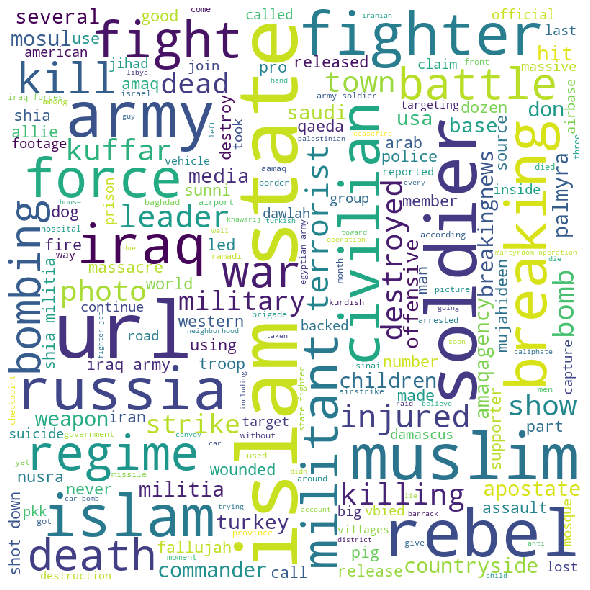

In [22]:
# generating word cloud to identify the key terms in  negative tweets
neagtive_tweets= df_tweets['tweet_nostopwords'][df_tweets['label']==-1]
tweet_joined_wordcloud=' '.join(join_tweets(neagtive_tweets))
#print(tweet_joined_wordcloud)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black',                 
                min_font_size = 10).generate(str(tweet_joined_wordcloud))   
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)   
plt.show() 

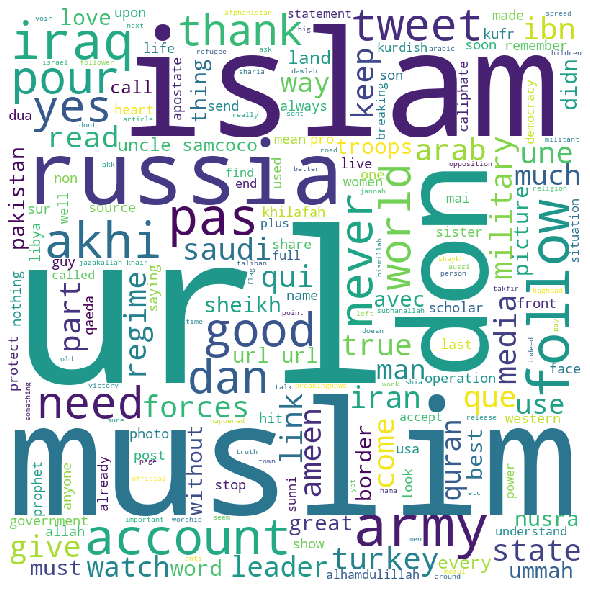

In [23]:
# generating word cloud to identify the key terms in  positive tweets
positive_tweets= df_tweets['tweet_nostopwords'][df_tweets['label']==1]
tweet_joined_wordcloud=' '.join(join_tweets(positive_tweets))
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black',                 
                min_font_size = 10).generate(str(tweet_joined_wordcloud))   
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)   
plt.show() 

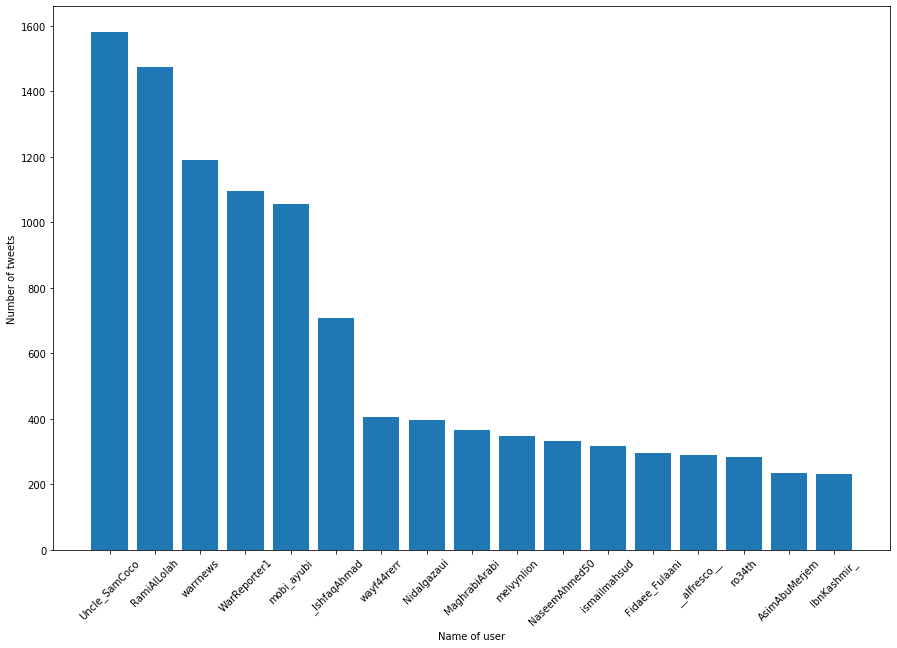

In [24]:
# Using a bar chart, visualizing the distribution of number of tweets by various users

df_tweet_resetindex=df_tweets.reset_index(level='username')
dict_username=df_tweet_resetindex['username'].value_counts()[df_tweet_resetindex['username'].value_counts()>200].to_dict()
fig= plt.figure(figsize=(15,10))
df_username = pd.Series(dict_username)
plt.bar(range(len(df_username)), df_username.values)
plt.xticks(range(len(df_username)), df_username.index.values)
plt.xticks(rotation=45)
plt.xlabel('Name of user') 
plt.ylabel('Number of tweets') 
plt.show()


In [42]:
df_tweets.to_csv('tweet_preprocessed.csv')


In [25]:
# using word2vec model to find similar words 
# attempt to build neural network model

w2v_model = Word2Vec(min_count=5,
                     window=4,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)
w2v_model.build_vocab(tweet_nostopwords, progress_per=10000)
w2v_model.train(tweet_nostopwords, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True)
w2v_model.wv.most_similar(topn=10,positive='militant')

[('airstrike', 0.9978469610214233),
 ('loses', 0.9975861310958862),
 ('jabal', 0.9973501563072205),
 ('province', 0.9972999095916748),
 ('managed', 0.9972988963127136),
 ('officials', 0.9972153902053833),
 ('retake', 0.9972083568572998),
 ('fleed', 0.9971762895584106),
 ('infiltrate', 0.997157633304596),
 ('sina', 0.9971418380737305)]

In [26]:
# using fasttext model to find similar words
# attempt to build neural network model

model = fasttext.train_unsupervised('tweets_clean.txt')
model.get_nearest_neighbors('militant')

[(0.8659542798995972, 'militant.'),
 (0.8395181894302368, '"militant'),
 (0.7884637713432312, 'eyeonmilitant'),
 (0.7595487236976624, 'militant"'),
 (0.6581793427467346, '155mm'),
 (0.6555309891700745, 'ingushetia'),
 (0.6495576500892639, 'militants)'),
 (0.6268077492713928, 'fatally'),
 (0.6237532496452332, 'enters'),
 (0.6204774379730225, 'yussuf')]

In [27]:
#Building a Naive bayes classification model using nltk library

from sklearn.model_selection import train_test_split
X=df_tweets["tweet_nostopwords"]
y=df_tweets["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42, stratify=y)

X_train = X_train.tolist() 
X_test = X_test.tolist() 
y_train = y_train.tolist() 
y_test = y_test.tolist() 

In [28]:
def processed_tweets(X,y):
    tweets=[]
    for tweet, label in zip( X,y):
        tweets.append((tweet,label))
    return tweets

In [29]:
def buildVocabulary(train_data):
    all_words = []
    
    for (words, sentiment) in train_data:
        all_words.extend(words)
    wordlist = nltk.FreqDist(all_words)
    word_features = wordlist.keys()
    
    return word_features

In [30]:
def extract_features(tweet):
    tweet_words = set(tweet)
    features = {}
    for word in word_features:        
        features['contains(%s)' % word] = (word in tweet_words)
    return features 


In [31]:
word_features = buildVocabulary(processed_tweets(X_train, y_train))
trainingFeatures = nltk.classify.apply_features(extract_features, processed_tweets(X_train, y_train))

In [32]:
NBayesClassifier = nltk.NaiveBayesClassifier.train(trainingFeatures)

In [33]:
pickle.dump( NBayesClassifier , open( "tweet_pickled.p", "wb" ) )

In [34]:
NBayesClassifier = pickle.load(open( "tweet_pickled.p", "rb" ))

In [35]:
NBResultLabels = [NBayesClassifier.classify(extract_features(tweet[0])) for tweet in processed_tweets(X_test,y_test)]

In [36]:
#checking the model performance

def model_performance():      
    print("Accuracy:",sklearn.metrics.accuracy_score(y_test, NBResultLabels))    
    print("F1 score:",sklearn.metrics.f1_score(y_test, NBResultLabels))
    print("Precision:",sklearn.metrics.precision_score(y_test, NBResultLabels))     
    print("roc-auc score:",sklearn.metrics.roc_auc_score(y_test, NBResultLabels))
    print("Recall",sklearn.metrics.recall_score(y_test, NBResultLabels))
    print("Confusion_matrix: \n",sklearn.metrics.confusion_matrix(y_test, NBResultLabels))
model_performance()

Accuracy: 0.8431935669155658
F1 score: 0.7980769230769231
Precision: 0.8155706727135299
roc-auc score: 0.8325913559316775
Recall 0.781317885590152
Confusion_matrix: 
 [[1857  244]
 [ 302 1079]]


In [37]:
#Building a Naive bayes clssification model using scikit learn as nltk doesn't  support cross validation

def make_xy(tweet, vectorizer=None):    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(tweet.tweet_tokens_joined)
    X = X.tocsc()  
    y = tweet.label.values.astype(np.int)
    return X, y
X, y = make_xy(df_tweets)

In [38]:
#Model performnce after cross validation

def model_performance_crossval():
    clf = MultinomialNB(alpha=.1)
    k_fold = KFold( n_splits=5, shuffle=True, random_state=0)
    print("Accuracy:", cross_val_score(clf, X, y, cv=k_fold, n_jobs=1,scoring='accuracy'))
    print("F1 score:",cross_val_score(clf, X, y, n_jobs=1, cv=k_fold,scoring='f1'))
    print("roc-auc score:",cross_val_score(clf, X, y, cv=k_fold, n_jobs=1,scoring='roc_auc'))
    print("precision:",cross_val_score(clf, X, y, cv=k_fold, n_jobs=1,scoring='precision'))
    print("recall:",cross_val_score(clf, X, y, cv=k_fold, n_jobs=1,scoring='recall'))
    y_pred = cross_val_predict(clf, X, y, cv=k_fold)
    conf_mat = confusion_matrix(y, y_pred)
    print("Confusion Matrix:\n", conf_mat)
model_performance_crossval()

Accuracy: [0.79006318 0.79063756 0.80068926 0.78173464 0.78805284]
F1 score: [0.70583501 0.70377895 0.72503962 0.69624301 0.71724138]
roc-auc score: [0.89688266 0.89288751 0.90438467 0.8908467  0.89116779]
precision: [0.79438406 0.78158845 0.78272027 0.78966455 0.7832636 ]
recall: [0.63504707 0.64005913 0.67527675 0.62258756 0.6614841 ]
Confusion Matrix:
 [[9293 1214]
 [2438 4465]]


In [39]:
#Removing empty rows and rows with a single word 
def emptyrows_remove(tweet, nostopwords):    
    min_words = 1
    tweet = tweet[nostopwords.apply(lambda x: True  if len(x)>min_words else False)]      
    return tweet

df_tweets = emptyrows_remove(df_tweets, df_tweets['tweet_nostopwords'])

In [40]:
# Checking performance after removing empty rows and rows with a single word 

X, y = make_xy(df_tweets)
model_performance_crossval()

Accuracy: [0.82063492 0.82825397 0.82343601 0.8316926  0.82661162]
F1 score: [0.72692122 0.73596877 0.73773585 0.75       0.73209028]
roc-auc score: [0.89744048 0.9056932  0.89795961 0.91014723 0.89921034]
precision: [0.77366255 0.75475475 0.77272727 0.79104478 0.78526316]
recall: [0.68550593 0.71809524 0.70577617 0.71300448 0.68566176]
Confusion Matrix:
 [[9180 1109]
 [1629 3829]]


In [50]:

df = pd.DataFrame(y,columns=['Output'])
df.to_excel(excel_writer = "C:\\Users\\USER\\Documents\\Geetha\\Data Science\\Github\\Springboard\\Capstone Poject 1\\test.xlsx",encoding="ISO-8859-1")
df_tweets['Prediction'] =df['Output']
